In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [139]:
x="2 Mar,3 Mar,4 Mar,5 Mar,6 Mar,7 Mar,8 Mar,9 Mar,10 Mar,11 Mar,12 Mar,13 Mar,14 Mar,15 Mar,16 Mar,17 Mar,18 Mar,19 Mar,20 Mar,21 Mar,22 Mar,23 Mar,24 Mar,25 Mar,26 Mar,27 Mar,28 Mar,29 Mar,30 Mar,31 Mar,1 Apr,2 Apr,3 Apr,4 Apr,5 Apr,6 Apr,7 Apr,8 Apr,9 Apr,10 Apr,11 Apr,12 Apr,13 Apr,14 Apr,15 Apr,16 Apr,17 Apr,18 Apr,19 Apr,20 Apr,21 Apr,22 Apr,23 Apr"
y=[1,0,0,0,1,1,3,0,1,3,4,2,6,3,8,7,1,6,22,28,29,46,46,2,2,74,70,81,48,47,24,9,40,84,80,58,56,10,12,70,77,58]
z = [1,0,2,3,5,5,2,5,4,9,24,25,36,32,18,24,32,39,56,51,43,83,85,135,175,165,186,139,179,430,317,292,399,344,361,255,268,336,392,318,315,322,155,291,390,354,307,411,367,263,222,366,371]

In [140]:
x = x.split(",")
x = [pd.to_datetime(f"{xi} 2020") for xi in x]

In [141]:
data = pd.DataFrame({'deaths': [0]*11 + y, 'cases': z}, index=x)

In [142]:
import plotting
import matplotlib.ticker as ticker

In [143]:
plt.style.use(plotting.pastle)

/home/daniel/.virtualenvs/gaston/sandbox/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


(0.10385635915967541, 100)

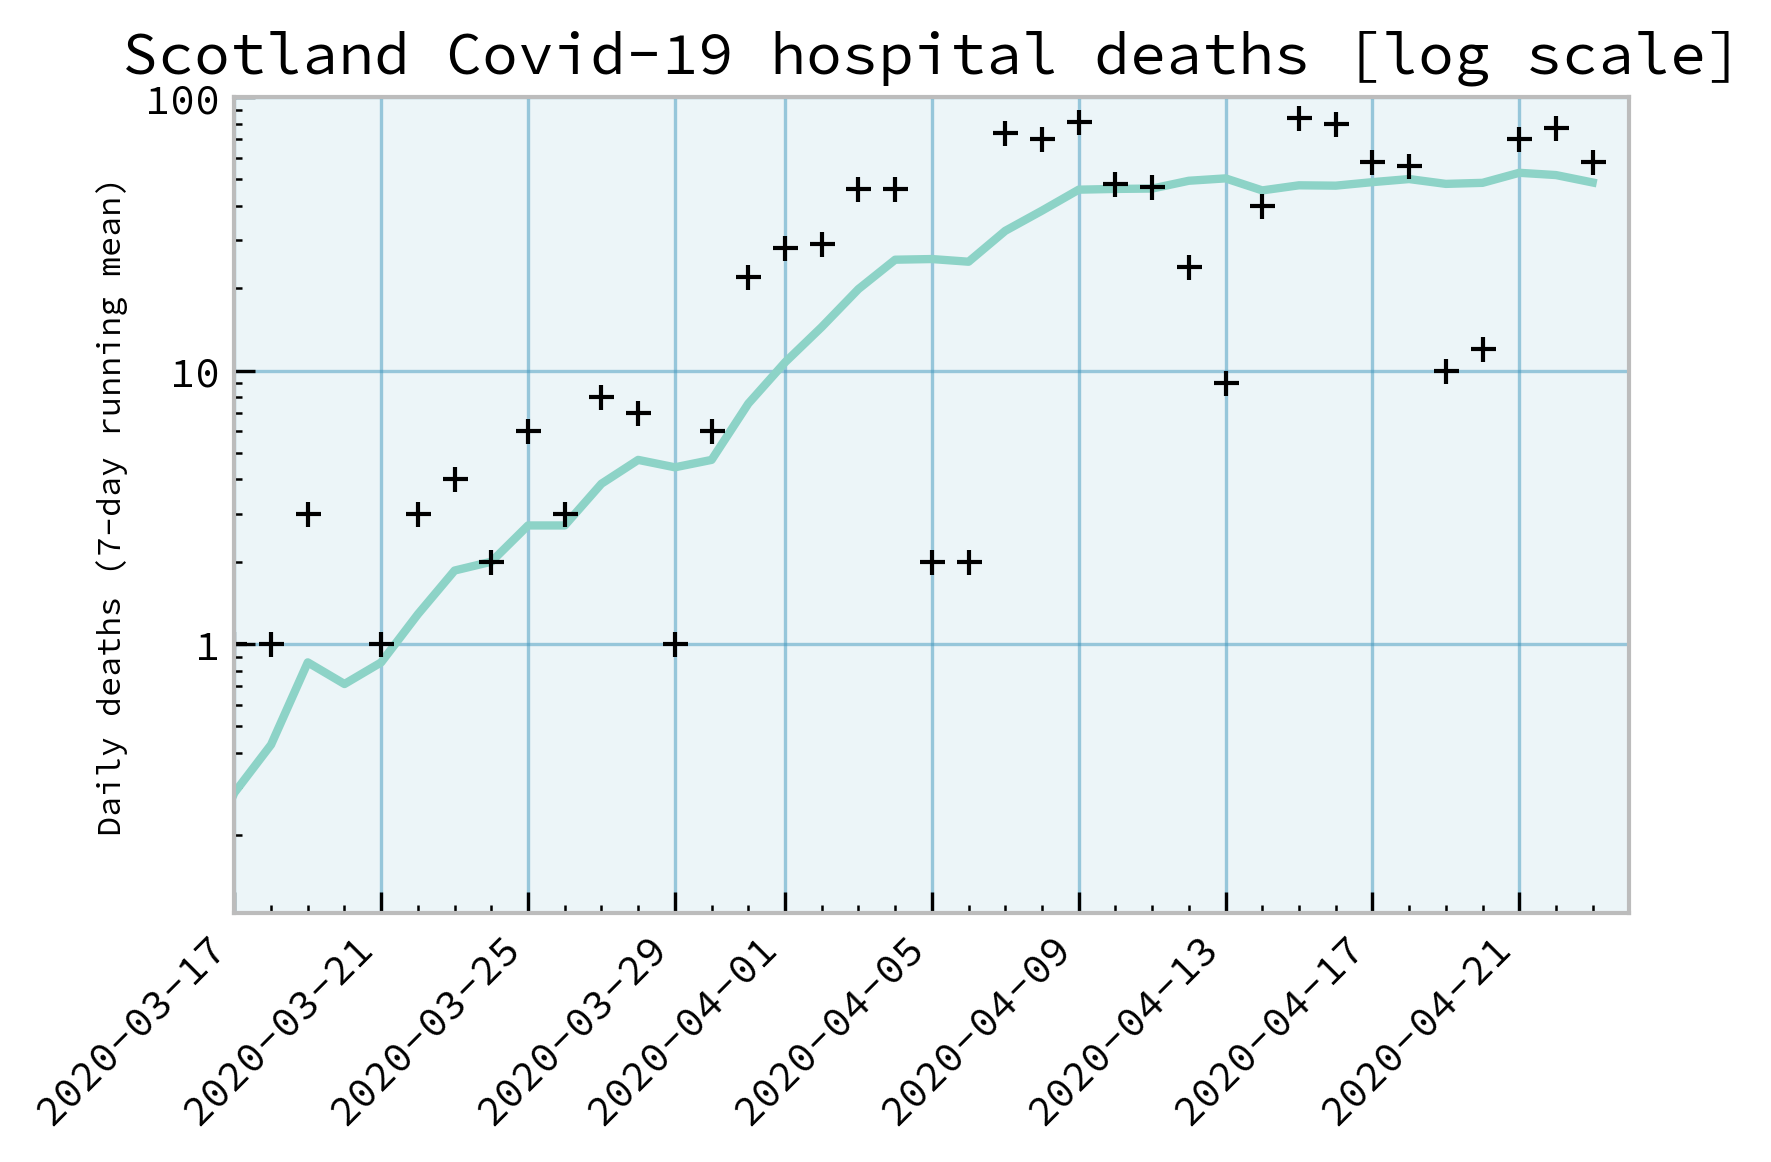

In [177]:
f, ax = plt.subplots(1,1, dpi=300)
ax.set_yscale("log")
ax.plot(data.deaths.rolling(window='7D').mean())
ax.plot(data.deaths, '+', color='k')
f.autofmt_xdate(rotation=45)
#ax.set_xlabel("Date")
ax.set_ylabel("Daily deaths (7-day running mean)")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.set_title("Scotland Covid-19 hospital deaths [log scale]")
ax.set_xlim([pd.to_datetime("2020-03-17"), pd.to_datetime("2020-04-24")])
ax.set_ylim([0,100])

(737485.0, 737538.0)

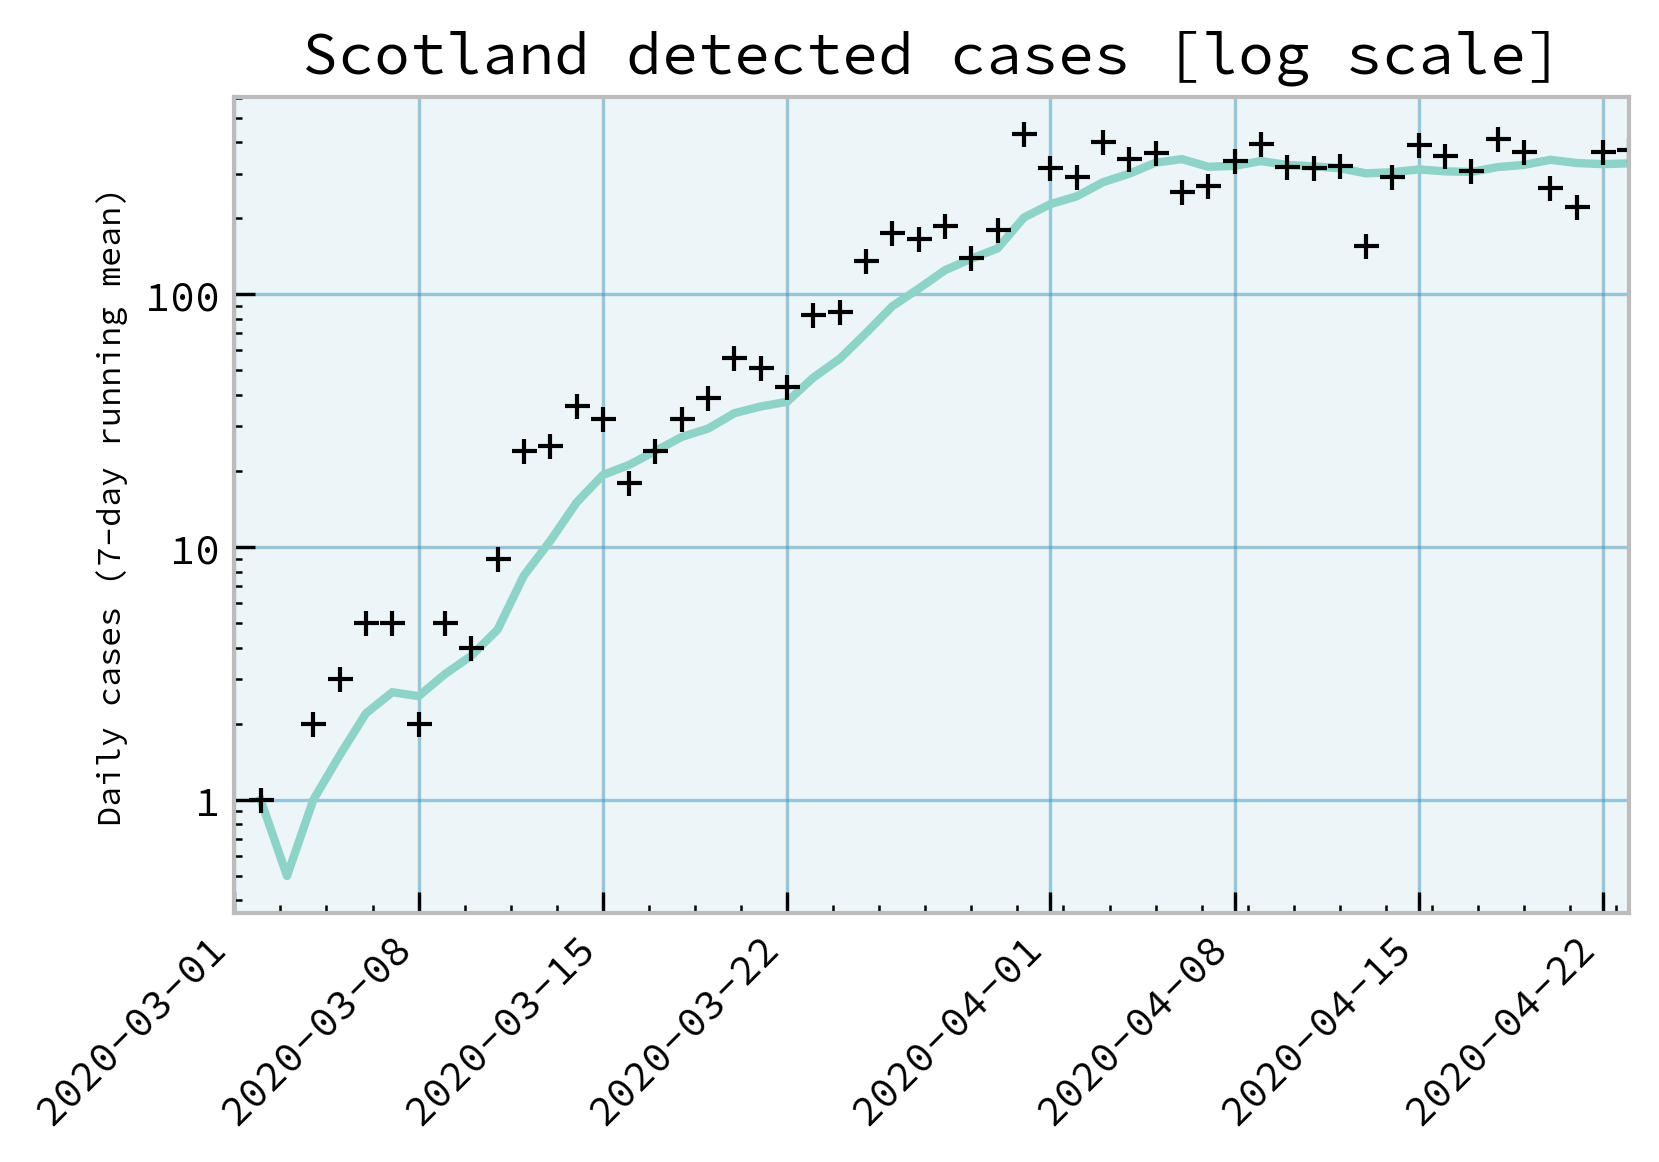

In [147]:
f, ax = plt.subplots(1,1, dpi=300)
ax.set_yscale("log")
ax.plot(data.cases.rolling(window='7D').mean())
ax.plot(data.cases, '+', color='k')
f.autofmt_xdate(rotation=45)
#ax.set_xlabel("Date")
ax.set_ylabel("Daily cases (7-day running mean)")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.set_title("Scotland detected cases [log scale]")
ax.set_xlim([pd.to_datetime("2020-03-01"), pd.to_datetime("2020-04-23")])
#ax.set_ylim([0,100])

In [148]:
import scipy.stats as sps
import numpy as np

In [149]:
data.cases[-1]

371

In [150]:
true_cases = np.linspace(0,1000,1000)

In [151]:
transmission = np.linspace(0,12,500)

In [152]:
gamma = 1./7

In [153]:
def likelihoods(data, rate):
    ł = data.values[:-1] * np.exp(gamma * (rate[:, None] - 1))
    l_transmission = sps.poisson.pmf(data.values[1:], ł)
    l_transmission = l_transmission / np.sum(l_transmission, axis=0)
    likelihoods = pd.DataFrame(index = rate, columns=data.index[1:], data=l_transmission)
    return likelihoods

In [154]:
lam = data.rolling(window='2D').mean().cases.values[:-1] * np.exp(gamma * (transmission[:, None] - 1))

In [155]:
l_transmission = likelihoods(data.cases, transmission)

/home/daniel/.virtualenvs/gaston/sandbox/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


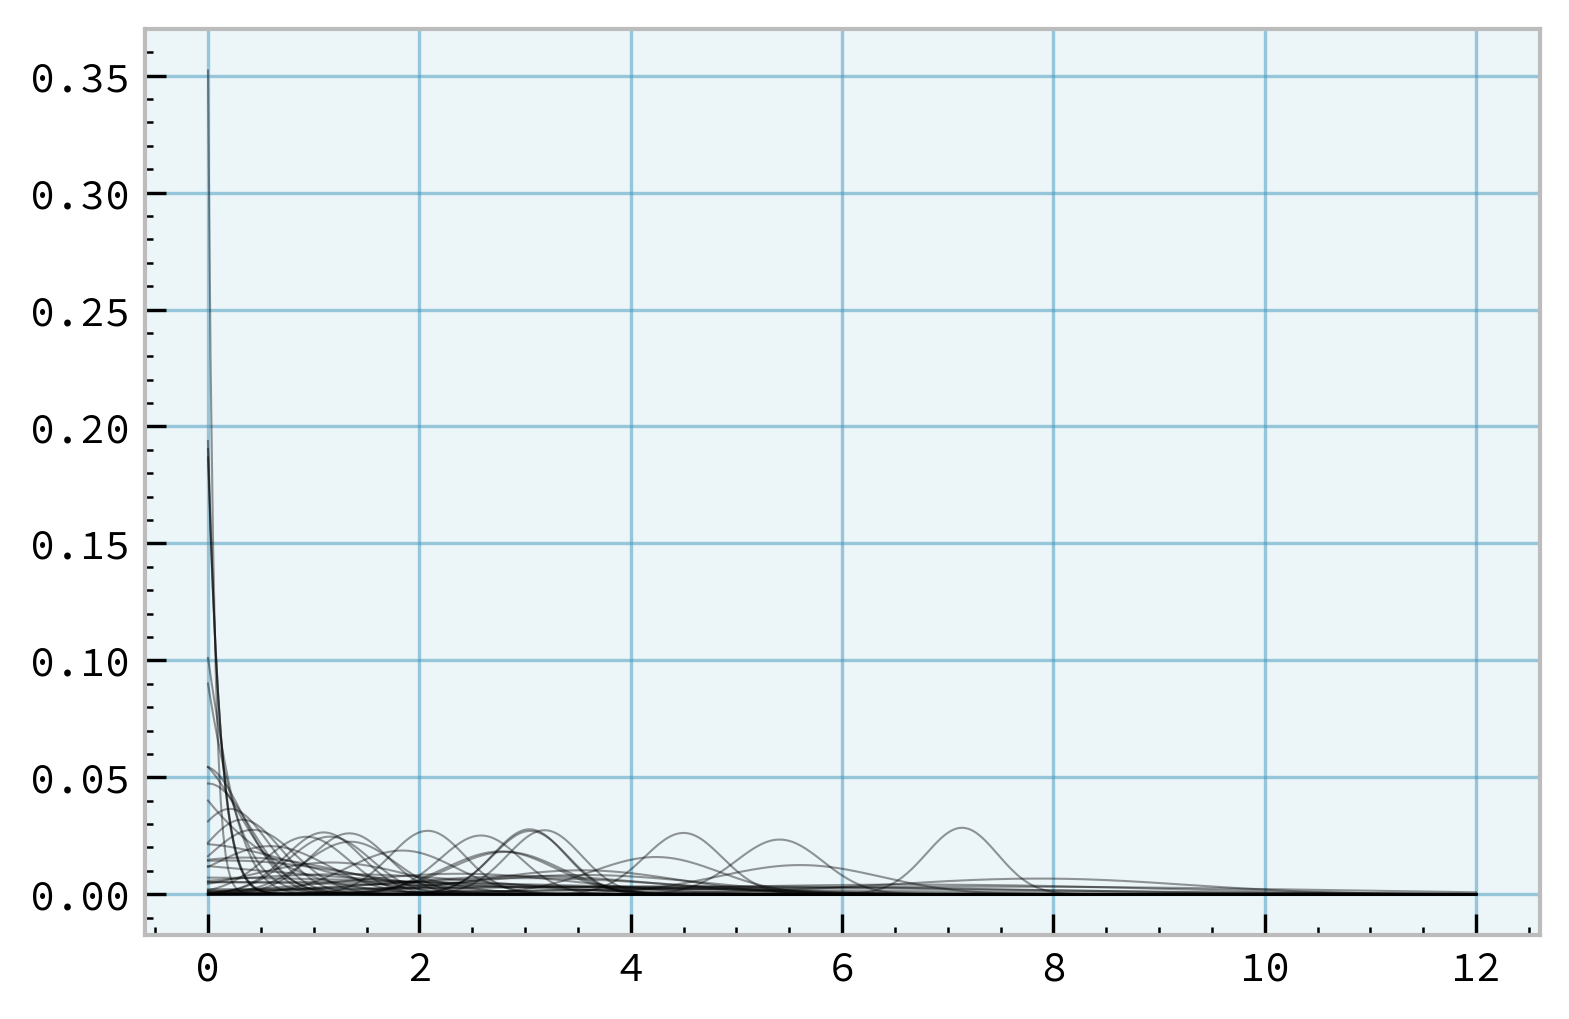

In [156]:
plt.plot(l_transmission, color='k', lw=0.5, alpha=0.4);

In [157]:
def priors(std = .2, rate = np.linspace(0,10,101)):
    initial_prior = np.ones_like(rate) / len(rate)
    initial_prior /= initial_prior.sum()
    
    prior_matrix = sps.norm(loc=rate, scale=std).pdf(rate[:,None])
    prior_matrix /= prior_matrix.sum(axis=0)
    return initial_prior, prior_matrix

In [158]:
def posterior(data, likelihoods, priors):
    initial_prior, prior_matrix = priors
    posteriors = pd.DataFrame(index=transmission, columns=data.index, data={data.index[0]: initial_prior})
    evidence = 0
    
    for yesterday, today in zip(data.index[:-1], data.index[1:]):
        current_prior = prior_matrix @ posteriors[yesterday]
        num = likelihoods[today] * current_prior
        den = np.sum(num)
        posteriors[today] = num/den
        
        evidence += den
    return posteriors, evidence

In [159]:
def hdi(distribution, p=0.99):
    """
    Calculate the highest-density confidence interval for a given distribution.
    """
    distribution = distribution.values
    lows, highs = ((np.cumsum(distribution) - np.cumsum(distribution)[:,None]) > p).nonzero()
    best = (highs - lows).argmin()
    return np.array([lows[best], highs[best]])

In [169]:
posteriors = posterior(data["2020-03-04":].rolling(window='7D').mean().round().cases[1:], 
                       likelihoods(data["2020-03-04":].rolling(window='7D').mean().round().cases, transmission), 
                       priors(0.1, transmission))

In [170]:
intervals = np.array([hdi(posteriors[0][i], p=0.9) for i in posteriors[0].columns])
maps = posteriors[0].idxmax()

/home/daniel/.virtualenvs/gaston/sandbox/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(0.0, 3.0)

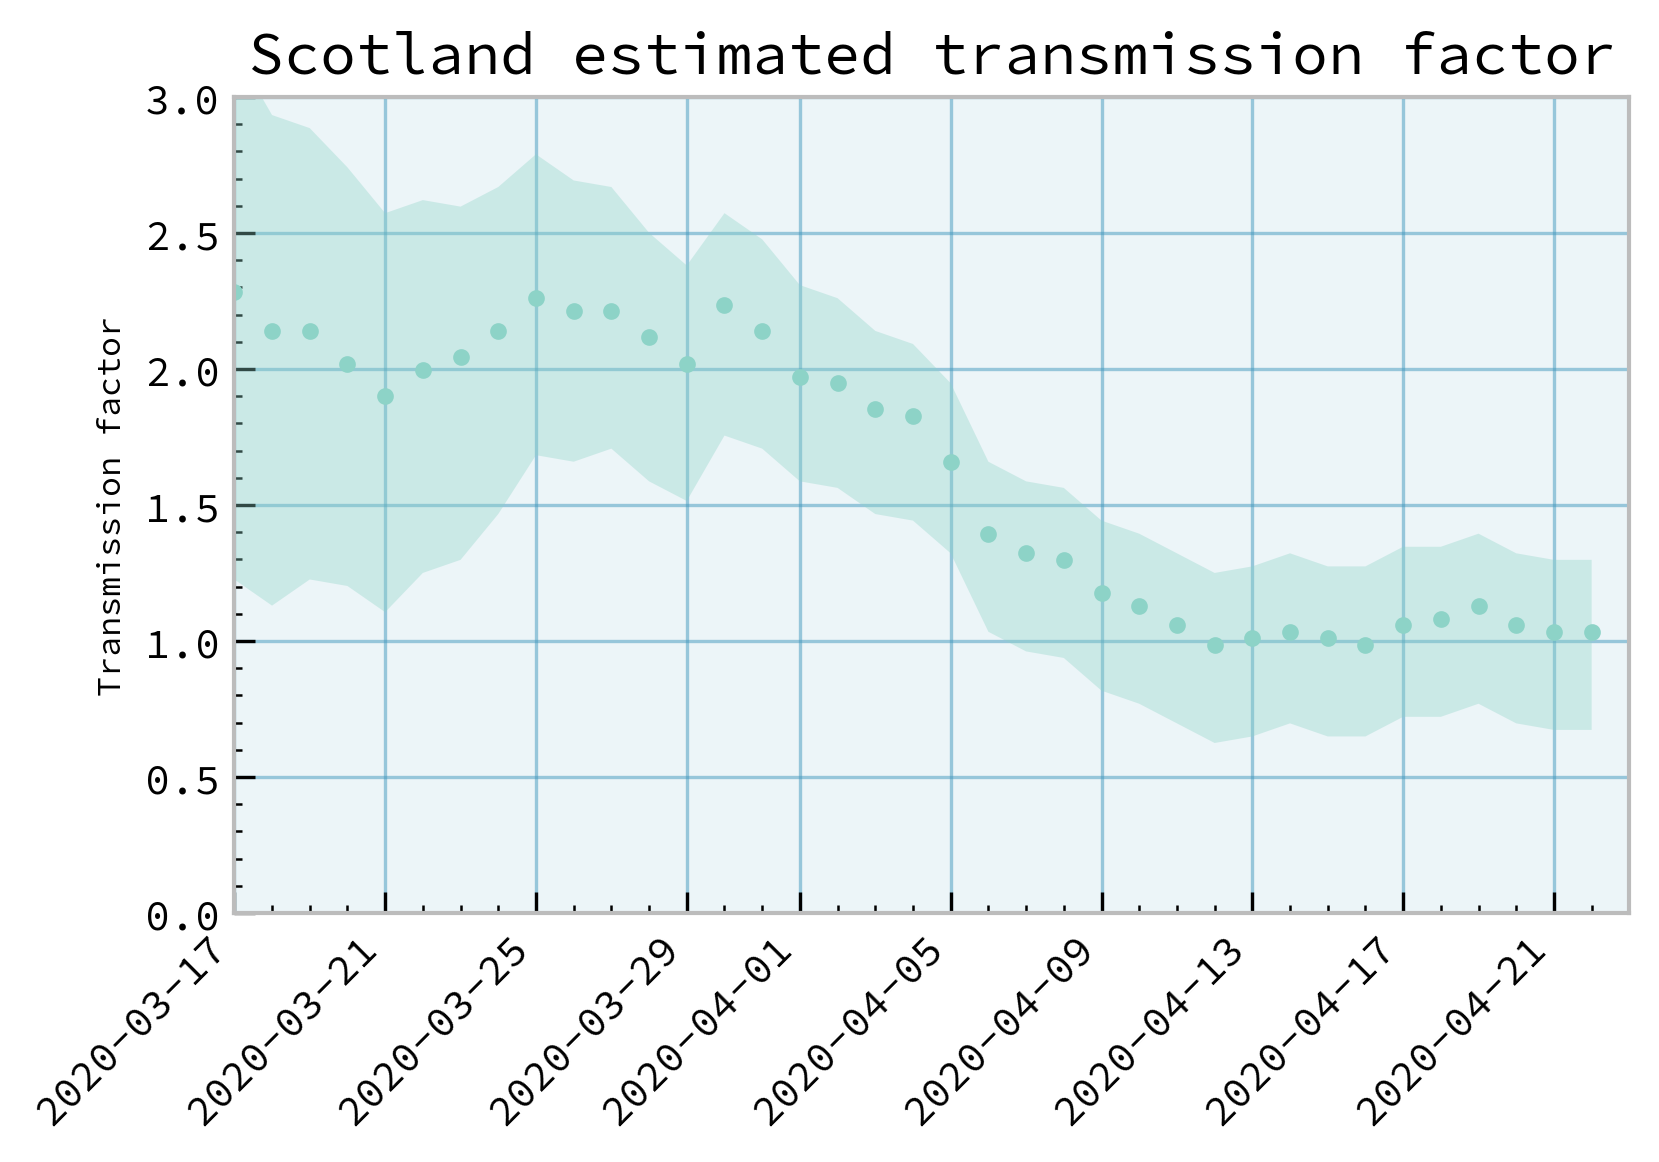

In [175]:
f, ax = plt.subplots(1,1)

ax.fill_between(data["2020-03-04":].index[:-1], posteriors[0].index[intervals][:,0], posteriors[0].index[intervals][:,1], alpha=0.35)
ax.plot(data["2020-03-04":].index[:-1],maps, '.')
f.autofmt_xdate(rotation=45)
#ax.set_xlabel("Date")
ax.set_ylabel("Transmission factor")
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.set_title("Scotland estimated transmission factor")
ax.set_xlim([pd.to_datetime("2020-03-17"), pd.to_datetime("2020-04-23")])
ax.set_ylim([0,3])

In [176]:
f.savefig("scotland-r.png")

In [103]:
evidences = [posterior(data.rolling(window='7D').mean().round().cases[1:], 
                       likelihoods(data.rolling(window='7D').mean().round().cases, transmission), 
                       priors(sigma, transmission))[1] for sigma in np.linspace(0,0.3,100)]

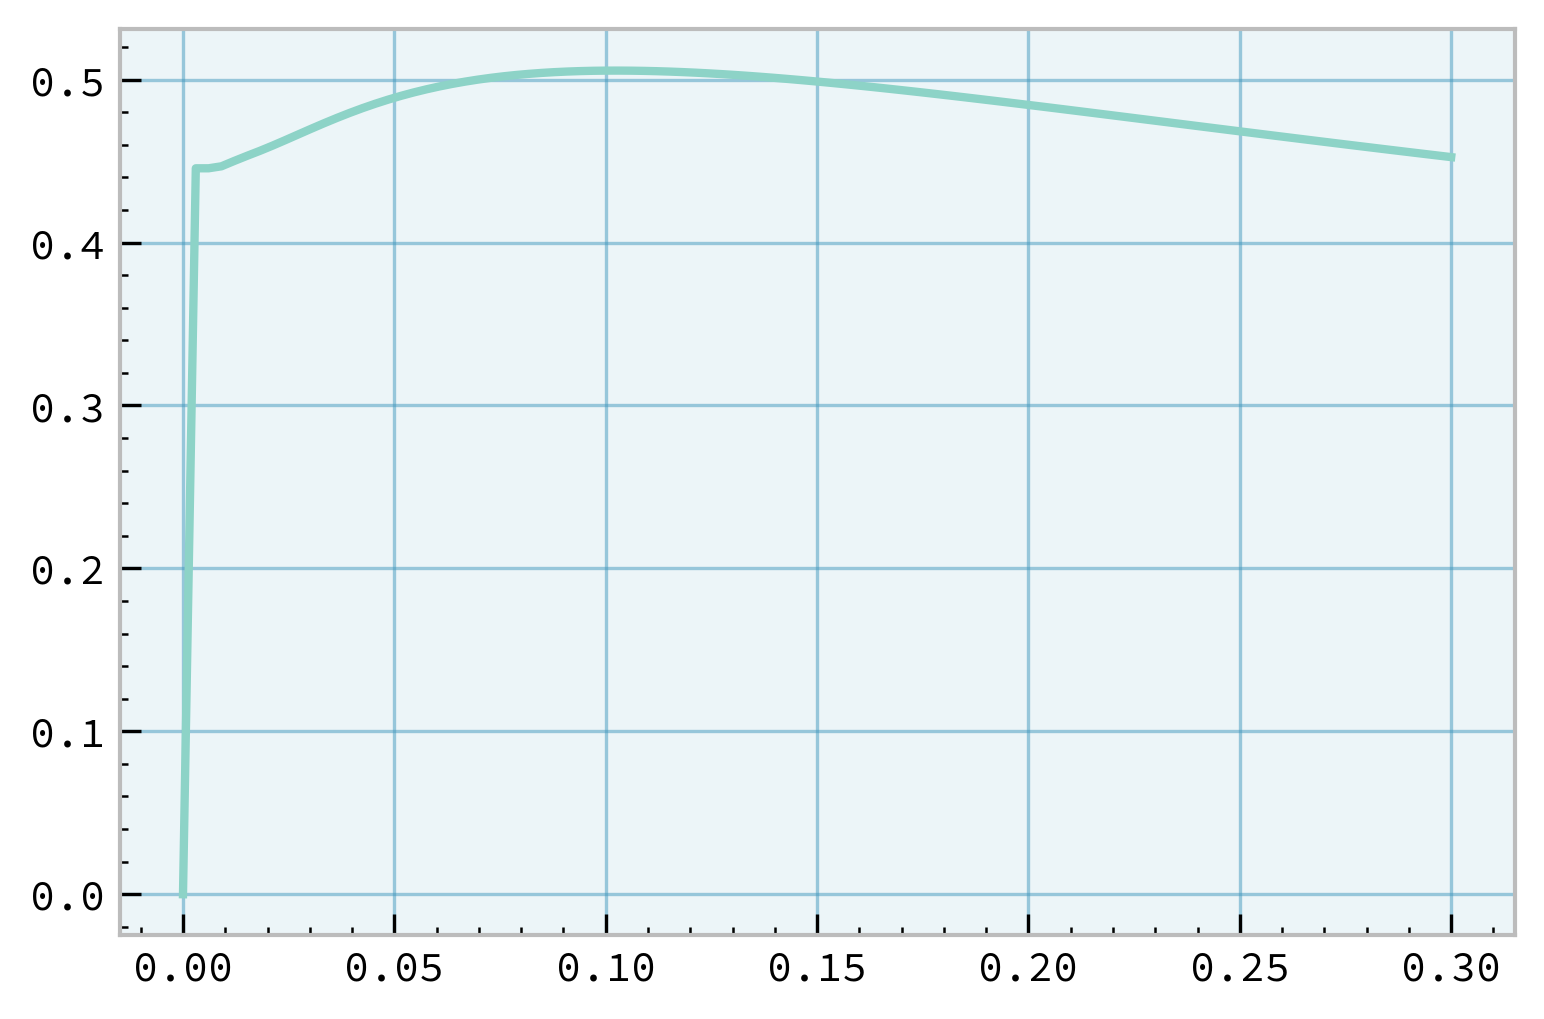

In [104]:
plt.plot(np.linspace(0,0.3,100), evidences)